[Reference](https://medium.com/@yulika.wijayanti/time-series-analysis-stock-price-forecasting-with-classical-time-series-to-deep-learning-method-1fe5edc0249b)

In [1]:
!pip install pmdarima
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 44.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.1 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=a90dec4d94c17dd277e3079a524b298b7910745b812643953a824eb16e9f5143
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from prophet import Prophet

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/yulikawijayanti/Project-TimeSeries-Univariate/master/data/BBCA.JK.csv")
df = df[['Date', 'Close']]

df.loc[:, 'Date'] = pd.to_datetime(df.loc[:, 'Date'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
df.head()

,Date,Close
0,2018-01-01,4380.0
1,2018-01-02,4380.0
2,2018-01-03,4380.0
3,2018-01-04,4445.0
4,2018-01-05,4450.0


In [7]:
split_time = 1000
train = df[:split_time]
test = df[split_time:]

train.shape, test.shape

((1000, 2), (125, 2))

In [8]:
#plot 1
pio.templates.default = "plotly_white"

st_fig = go.Figure()

line1 = go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train')
line2 = go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test')

st_fig.add_trace(line1)
st_fig.add_trace(line2)
st_fig.update_layout(title='Daily Close Stock Price BBCA Period 2018-2022')
st_fig.show()

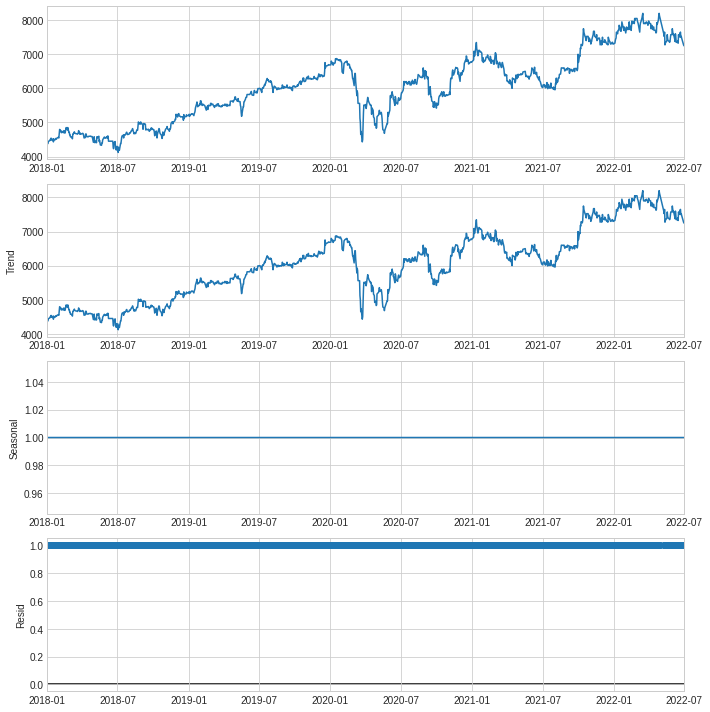

In [9]:
# plot 2
sd = df.copy().dropna()
sd.set_index('Date', inplace=True)

plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(10,10))

fig = seasonal_decompose(sd, model='multiplicative', period=1).plot()

fig.show()

# ARIMA (Autoregressive Integrated Moving Average)


In [10]:
result = adfuller(train['Close'])
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'])
print(f'KPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

ADF Stattistics : -1.531829948563764
P-value : 0.5177109001310636
KPSS Stattistics : 3.7931630312874
P-value : 0.01


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




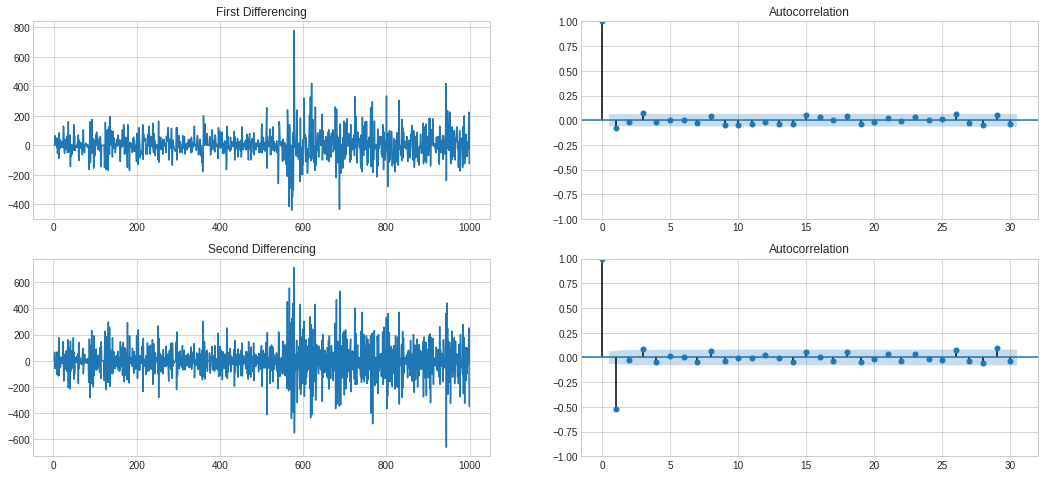

In [11]:
# Plot ACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_acf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_acf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



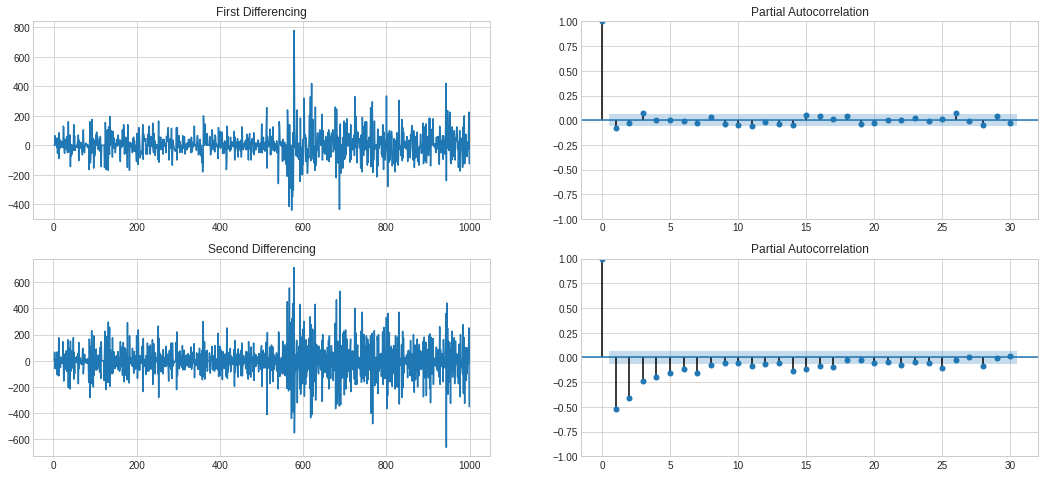

In [12]:
#Plot PACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_pacf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_pacf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

In [13]:
ndiffs(train['Close'], test='adf')

1

In [14]:
result = adfuller(train['Close'].diff().dropna())
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'].diff().dropna())
print(f'\nKPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

if result[1] < 0.05 and result_kpss[1] > 0.05:
  print('\nConclusion : Data stationer\n')
else:
  print('\nConclusion : Data not stationer\n')

ADF Stattistics : -17.615768387860527
P-value : 3.860024785712472e-30

KPSS Stattistics : 0.030162743597226267
P-value : 0.1

Conclusion : Data stationer



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



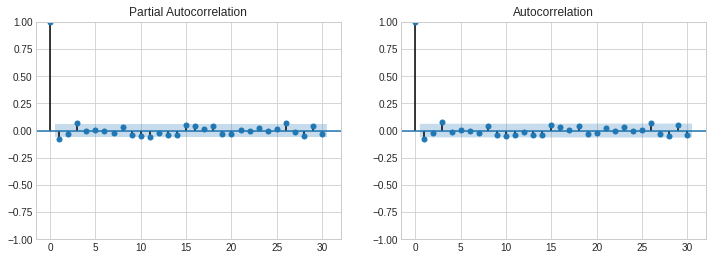

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

diff_once = train['Close'].diff()
plot_pacf(diff_once.dropna(), ax=ax[0])
plot_acf(diff_once.dropna(), ax=ax[1])

plt.show()

In [16]:
model1 = ARIMA(train['Close'], order=(1, 1, 1), trend='t')
result1 = model1.fit()
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5929.085
Date:                Sun, 31 Jul 2022   AIC                          11866.170
Time:                        14:27:48   BIC                          11885.797
Sample:                             0   HQIC                         11873.630
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9982      2.782      1.078      0.281      -2.454       8.450
ar.L1          0.0439      0.278      0.158      0.874      -0.501       0.589
ma.L1         -0.1237      0.275     -0.450      0.6

In [17]:
model2 = ARIMA(train['Close'], order=(0, 1, 1), trend='t')
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -5929.102
Date:                Sun, 31 Jul 2022   AIC                          11864.204
Time:                        14:27:57   BIC                          11878.924
Sample:                             0   HQIC                         11869.799
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9980      2.735      1.096      0.273      -2.362       8.358
ma.L1         -0.0805      0.023     -3.555      0.000      -0.125      -0.036
sigma2      8400.0340    174.191     48.223      0.0

In [18]:
model3 = ARIMA(train['Close'], order=(1, 1, 0), trend='t')
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1000
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5929.218
Date:                Sun, 31 Jul 2022   AIC                          11864.436
Time:                        14:28:05   BIC                          11879.157
Sample:                             0   HQIC                         11870.031
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9980      2.749      1.090      0.276      -2.391       8.387
ar.L1         -0.0779      0.023     -3.395      0.001      -0.123      -0.033
sigma2      8378.5025    175.718     47.682      0.0

In [19]:
#Prediction
prediction_arima = result1.get_prediction(start=1, end=len(df))
pred = prediction_arima.predicted_mean

pred_df = pd.DataFrame(pred.values, columns=['pred']).join(df['Date'])

In [20]:
#Forecast Next 100 Days
n_forecast = 100

forecast_arima = result1.get_forecast(steps=n_forecast)

yhat = forecast_arima.predicted_mean
yhat_conf_int = forecast_arima.conf_int(alpha=0.05)

yhat_date = pd.DataFrame(pd.date_range(start = '2022-07-01', periods = 100, freq='B'), columns=['Date'])

yhat_df = pd.DataFrame(yhat.values,  columns=['yhat']).join(yhat_date)

In [21]:
# Result Forecast
yhat_df

,yhat,Date
0,7386.051020,2022-07-01
1,7389.403096,2022-07-04
2,7392.416847,2022-07-05
3,7395.415731,2022-07-06
4,7398.413961,2022-07-07
...,...,...
95,7671.250178,2022-11-11
96,7674.248378,2022-11-14
97,7677.246578,2022-11-15
98,7680.244778,2022-11-16


In [22]:
lower_series = pd.DataFrame(yhat_conf_int['lower Close'].values, columns=['lower']).join(yhat_date)
upper_series = pd.DataFrame(yhat_conf_int['upper Close'].values, columns=['upper']).join(yhat_date)

In [23]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = pred_df['Date'], y = pred_df['pred'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Prediction'))
st_fig.add_trace(go.Scatter(x = yhat_df['Date'], y = yhat_df['yhat'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Forecasting'))

st_fig.add_traces(go.Scatter(x=lower_series['Date'], y = lower_series['lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=upper_series['Date'], y = upper_series['upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.update_layout(title='ARIMA (0,1,1)')
st_fig.show()

In [24]:
rmse_arima =  mean_squared_error(test['Close'], pred_df['pred'][split_time:], squared=False)
rmse_arima

310.2014399194205

In [25]:
# Prepare Dataset

scaler = StandardScaler()
train_scale = pd.DataFrame(scaler.fit_transform(np.array(train['Close']).reshape(-1,1)), columns=['Close'])
train_scale_df = train[['Date']].join(train_scale)

test_scale = pd.DataFrame(scaler.transform(np.array(test['Close']).reshape(-1,1)), index=test.index, columns=['Close'])
test_scale_df = test[['Date']].join(test_scale)

In [26]:
window_size=10

train_generator = TimeseriesGenerator(train_scale_df['Close'].to_numpy(), 
                                      train_scale_df['Close'].to_numpy(), length=window_size, batch_size=28)  
   
test_generator = TimeseriesGenerator(test_scale_df['Close'].to_numpy(), 
                                     test_scale_df['Close'].to_numpy(), length=window_size, batch_size=1)

In [27]:
# Modeling
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, input_shape=(window_size,1), return_sequences=True),
        tf.keras.layers.LSTM(50, return_sequences=True),
        tf.keras.layers.LSTM(10),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mape'])

history = model.fit(train_generator,epochs=100)

Epoch 1/100
36/36 [==============================] - 11s 34ms/step - loss: 0.6954 - mape: 112.1778
Epoch 2/100
36/36 [==============================] - 1s 32ms/step - loss: 0.1992 - mape: 162.2897
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 0.1056 - mape: 202.3671
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.0815 - mape: 136.9803
Epoch 5/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0627 - mape: 130.4677
Epoch 6/100
36/36 [==============================] - 1s 34ms/step - loss: 0.0736 - mape: 111.2754
Epoch 7/100
36/36 [==============================] - 1s 29ms/step - loss: 0.0609 - mape: 104.6695
Epoch 8/100
36/36 [==============================] - 1s 32ms/step - loss: 0.0558 - mape: 126.2380
Epoch 9/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0517 - mape: 101.1075
Epoch 10/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0746 - mape: 94.6465
Epoch 11/100
36/36 

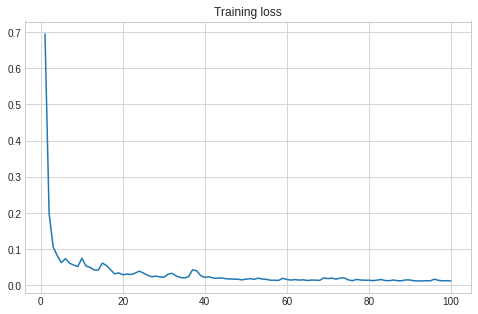

In [28]:
plt.figure(figsize=(8,5))

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss)
plt.title('Training loss')

plt.show()

In [29]:
#Prediction

train_predict = model.predict(train_generator)
train_predict = pd.DataFrame(scaler.inverse_transform(train_predict.reshape(-1,1)), columns=['Close'])

test_predict = model.predict(test_generator)
test_predict = pd.DataFrame(scaler.inverse_transform(test_predict.reshape(-1,1)), columns=['Close'])

In [30]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = train['Date'][10:], y = train_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Train Prediction'))
st_fig.add_trace(go.Scatter(x = test['Date'][10:], y = test_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Test Prediction'))


st_fig.update_layout(title='LSTM')
st_fig.show()

In [31]:
# Forcasting

def predict(num_prediction, model):
    prediction_list = test_scale['Close'].to_numpy()[-window_size:]

    for _ in range(num_prediction):
      x = prediction_list[-window_size:]
      x = x.reshape(1, window_size, 1)
      out = model.predict(x)
      prediction_list = np.append(prediction_list, out)

    forecast = prediction_list[window_size:]
    forecast = pd.DataFrame(scaler.inverse_transform(forecast.reshape(-1,1)), columns=['Close'])
    forecast['Date'] = pd.date_range(start = test['Date'].to_list()[-1] + pd.DateOffset(days=1), periods = num_prediction, freq='B')

    return forecast

In [32]:
forecast_lstm = predict(100, model)

In [33]:
# Result Forecast
forecast_lstm

,Close,Date
0,7247.740104,2022-07-04
1,7239.133443,2022-07-05
2,7228.727044,2022-07-06
3,7217.938888,2022-07-07
4,7207.297669,2022-07-08
...,...,...
95,6253.588161,2022-11-14
96,6253.172089,2022-11-15
97,6252.819155,2022-11-16
98,6252.521298,2022-11-17


In [34]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = train['Date'][10:], y = train_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Train Prediction'))
st_fig.add_trace(go.Scatter(x = test['Date'][10:], y = test_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Test Prediction'))

st_fig.add_trace(go.Scatter(x = forecast_lstm['Date'], y = forecast_lstm['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Forecast'))


st_fig.update_layout(title='LSTM + Forecast')
st_fig.show()

In [35]:
rmse_lstm =  mean_squared_error(test['Close'][10:], test_predict['Close'], squared=False)
rmse_lstm

240.63925568634

In [36]:
train_fp = pd.DataFrame({'ds' : train['Date'], 'y' : train['Close']})
train_fp.head()

,ds,y
0,2018-01-01,4380.0
1,2018-01-02,4380.0
2,2018-01-03,4380.0
3,2018-01-04,4445.0
4,2018-01-05,4450.0


In [37]:
model_fp = Prophet(daily_seasonality=True)
model_fp.fit(train_fp)

14:32:41 - cmdstanpy - INFO - Chain [1] start processing
14:32:41 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
future = model_fp.make_future_dataframe(periods=len(test)+100, freq='B')
future.tail()

,ds
1220,2022-10-25
1221,2022-10-26
1222,2022-10-27
1223,2022-10-28
1224,2022-10-31


In [39]:
forecast = model_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1220,2022-10-25,7923.049853,6872.559454,8989.872596
1221,2022-10-26,7936.587317,6932.274324,9005.081921
1222,2022-10-27,7946.979243,6907.690825,9031.514502
1223,2022-10-28,7955.342640,6883.807247,9042.503781
1224,2022-10-31,7984.731371,6901.155934,9085.625172


In [40]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()


st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['yhat'], 
                            line = dict(color='green', width=2, dash='dot'), name= 'Forecasting'))


st_fig.update_layout(title='FB Prophet')
st_fig.show()

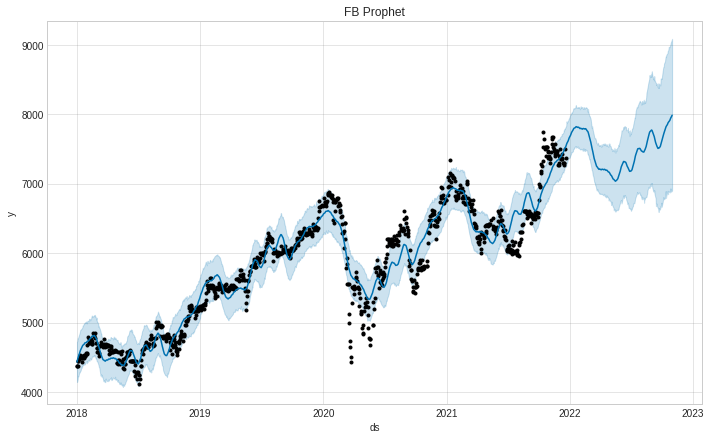

In [41]:
model_fp.plot(forecast)
plt.title('FB Prophet')
plt.show()

In [42]:
rmse_fp =  mean_squared_error(test['Close'], forecast['yhat'][split_time:split_time+len(test)], squared=False)
rmse_fp

411.4355078446341

In [43]:
pd.DataFrame({'Model' : ['ARIMA', 'LSTM', 'FB Prophet'],
              'RMSE Test Set': [rmse_arima, rmse_lstm, rmse_fp]})

,Model,RMSE Test Set
0,ARIMA,310.201440
1,LSTM,240.639256
2,FB Prophet,411.435508
